<a href="https://colab.research.google.com/github/acutkosky/parameter_free_demo/blob/master/parameter_free.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import numpy as np
from scipy.stats import ortho_group
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)


#Base Class

base class for online learners that can add various reductions. Right now it includes:
 * anytime online-to-batch. https://arxiv.org/abs/1903.00974
 * adding weighted average for [metagrad](https://papers.nips.cc/paper/6268-metagrad-multiple-learning-rates-in-online-learning)-like bounds that can adapt to strong-convexity as in Algorithm 6 [here](http://proceedings.mlr.press/v75/cutkosky18a/cutkosky18a.pdf). This one technically only works with parameter-free algorithms, not other things like AdaGrad. That doesn't mean you can't try it anyway though, of course.

In [ ]:
# base class for online learners that can add various reductions. Right now it includes:
# anytime online-to-batch https://arxiv.org/abs/1903.00974
# adding weighted average for metagrad-like bounds as in https://arxiv.org/abs/1802.06293 (algorithm 6)
# ^ this second one technically only works with parameter-free algs, not other things like adagrad.
#   That doesn't mean you can't try it anyway though, of course.
class Optimizer(object):
    def __init__(self, initial_var_value, do_online_to_batch=False, add_average=False):
        self.initial_var_value = initial_var_value
        self.average_offset = 0
        self.iteration_count = 0
        self.do_OTB = do_online_to_batch
        self.add_average = add_average
        self.sum_squared_grad = 0.00001
        self.weighted_offset = 0
        self.last_iterate=initial_var_value

    def get_last_iterate(self):
      return self.last_iterate

    def update(self, grad, loss):
        # call this to update the optimizer. the return value is the next iterate.
        self.iteration_count += 1

        # get output from actual optimizer.
        offset = self.apply_grad(grad, loss)

        if self.add_average:
            # statistics used to compute weighted averages
            grad_squared = np.linalg.norm(grad)#grad**2
            self.sum_squared_grad += grad_squared
            self.weighted_offset += grad_squared * (self.last_iterate - self.weighted_offset)/self.sum_squared_grad
            # add weighted average of past iterates for metagrad-esque bounds.
            offset = offset + self.weighted_offset

        self.last_offset = offset

        # unweighted average iterate for anytime online-to-batch.
        self.average_offset += (offset - self.average_offset) / self.iteration_count

        if self.do_OTB:
            # do anytime online-to-batch conversion from https://arxiv.org/abs/1903.00974
            self.last_iterate = self.initial_var_value + self.average_offset
        else:
            self.last_iterate = self.initial_var_value + offset

        return self.last_iterate


    def apply_grad(self, grad, loss):
        raise NotImplementedError



# Adagrad
Implementation as described [here](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf).

In [ ]:
# Adagrad implementation
class AdaGrad(Optimizer):
    def __init__(self, initial_var_value, lr, **kwargs):
        super(AdaGrad, self).__init__(initial_var_value, **kwargs)
        self.lr = lr
        self.sum_squared_grad = 0.0001 #small number for numerical stability
        self.w = 0
    
    def apply_grad(self, grad, loss):
        # loss is unused here

        grad_magnitude_squared = grad**2
        self.sum_squared_grad += grad_magnitude_squared

        eta = self.lr/np.sqrt(self.sum_squared_grad)

        self.w -=  eta * grad
        return self.w


# ONS Coin Betting with per-coordinate updates
Uses coin betting based on online-newton-step as described in algorithm 1 of [this paper](http://proceedings.mlr.press/v75/cutkosky18a/cutkosky18a.pdf).

In [ ]:

# coin betting algorithm, using 
# ons-based techniqe from http://proceedings.mlr.press/v75/cutkosky18a/cutkosky18a.pdf
# (algorithm 1), applied on each coordinate independently.
# initial wealth is the initial amount of money for the coin better
# domain restricts the betting fraction to be in the range [-domain, domain]
# both of these have only logarithmic effect on the regret bound.
class ONS_CB(Optimizer):
    def __init__(self, initial_var_value, initial_wealth=1.0, domain=0.5, **kwargs):
        # propogate keyword arguments to base class
        super(ONS_CB, self).__init__(initial_var_value, **kwargs)

        self.wealth = initial_wealth

        self.domain = domain

        self.sum_grad = 0
        self.max_grad = 0.000001
        self.w = 0 #current iterate value

        self.beta = 0


        self.sum_z_squared = 0.00001
        self.sum_z = 0



    def apply_grad(self, grad, loss):
        # loss is unused here

        # truncated_grad = np.clip(grad, -self.max_grad, self.max_grad)
        self.max_grad = np.maximum(np.abs(grad), self.max_grad)
        grad = grad/self.max_grad
        # grad = truncated_grad


        # compute gradient of beta-loss L(beta) = -log(1-beta *grad)
        z = grad/(1.0 - self.beta * grad)


        ### do Online Newton Step (ONS) update on L(beta)
        self.sum_z_squared += z**2
        self.sum_z += z
        ONS_eta = 2.0/(2.0 - np.log(3.0)) # magic constant related to logarithms and 0.5...
        domain = self.domain
        ONS_eta = -0.5 * domain**2/(domain + np.log(1-domain))
        self.beta = np.clip(self.beta - ONS_eta * z / self.sum_z_squared, -domain, domain)
        # self.beta = np.clip(-ONS_eta * self.sum_z/self.sum_z_squared, -0.5, 0.5)
        ###

        self.wealth -= grad * self.w

        
        self.w = self.beta * self.wealth
        # print("w: ",self.w)
        # print("self.beta: ", self.beta)


        return self.w



#ONS Coin Betting with dimension-free regret bound

Uses sign-based conversion from 1D to dimension-free as described in Algorithm 4 of Ashok's [thesis](https://cs.stanford.edu/~ashokc/papers/thesis.pdf.).

In [ ]:
class ONS_CB_dim_free(Optimizer):
    def __init__(self, initial_var_value, initial_wealth=1.0, domain=0.5, **kwargs):
        # propogate keyword arguments to base class
        super(ONS_CB_dim_free, self).__init__(initial_var_value, **kwargs)

        self.wealth = initial_wealth
        self.domain = domain

        self.sum_grad = 0
        self.sum_squared_grad = 0.0001
        self.max_grad = 0.000001
        self.magnitude = 0

        self.beta = 0


        self.sum_z_squared = 1.0
        self.sum_z = 0

        self.sum_signs = 0
        # self.sum_grad_direction = np.zeros_like(initial_var_value)
        self.direction = np.zeros_like(initial_var_value)


    def apply_grad(self, grad, loss):
        # loss is unused here


        magnitude_grad = np.dot(grad, self.direction)
        truncated_grad = np.clip(magnitude_grad, -self.max_grad, self.max_grad)
        self.max_grad = np.maximum(np.linalg.norm(grad), self.max_grad)
        magnitude_grad = magnitude_grad/self.max_grad


        # compute gradient of beta-loss L(beta) = -log(1-beta *grad)
        z = magnitude_grad/(1.0 - self.beta * magnitude_grad)


        ### do Online Newton Step (ONS) update on L(beta)
        self.sum_z_squared += z**2
        self.sum_z += z
        domain = self.domain
        ONS_eta = -0.5 * domain**2/(domain + np.log(1-domain))
        # ONS_eta = 2.0/(2.0 - np.log(3.0)) # magic constant related to logarithms and 0.5...
        self.beta = np.clip(self.beta - ONS_eta * z / self.sum_z_squared, -domain, domain)
        # self.beta = np.clip(-ONS_eta * self.sum_z/self.sum_z_squared, -0.5, 0.5)
        ###

        self.wealth -= magnitude_grad * self.magnitude

        self.magnitude = self.beta * self.wealth

        # print("mag: ",magnitude_grad)

        # direction update. uses "sign based" N-D to 1-D reduction
        # described in Algorithm 4 of https://cs.stanford.edu/~ashokc/papers/thesis.pdf
        self.sum_grad += grad
        self.sum_squared_grad += np.linalg.norm(grad)**2
        self.sum_signs += magnitude_grad
        self.direction = -self.sum_grad/np.sqrt(2*self.sum_squared_grad)
        if np.linalg.norm(self.direction) > 1.0:
            self.direction = self.direction/np.linalg.norm(self.direction)
        # np.sign(self.sum_signs+0.000001) * self.sum_grad/(0.00000001 + np.linalg.norm(self.sum_grad))

        return self.magnitude * self.direction

# Loss Definition

The expected loss function is given by $\mathcal{L}(x) = \ell(\|M(x-x_\star)\|)$, where $M\in \mathbb{R}^{d\times d}$ is a symmetric PSD matrix with exponentially decaying eigenvalues and $\ell$ is a smoothed version of the absolute loss:

$$
\ell(x) = \left\{ 
  \begin{array}{lr}
  t^2&\text{ if }t<1 \\
  2|t|-1&\text{ otherwise}
  \end{array}\right.
$$

So that the loss is zero at $x_\star$.
The stochastic gradient oracle is given by $g_t = \nabla \mathcal{L}(x) + \tau M\zeta_t$ where each $\zeta_t$ is an independent mean-zero Gaussian random variable with identity covariance and $\tau$ is a "noise magnitude" parameter supplied by the user.

We can also use the non-smoothed absolute loss $\mathcal{L}(x) = \|M(x-x_\star)\|$ by providing an appropriate switch to the loss generator function.

In [ ]:
# returns smoothed absolute loss and its derivative
# use smoothed loss so that things with second-order bounds can 
# take advantage of smoothness.
def smoothed_absolute_loss(t):
    if t<1:
        return t**2, 2*t
    else:
        return 2*np.abs(t) - 1.0, 2*np.sign(t)

def absolute_loss(t):
  return np.abs(t) , np.sign(t)

### optimization problem: linear regression with smoothed absolute loss
# This function returns another function that generates loss values and gradients
# given an iterate value.
def loss_function_factory(dims, noise_magnitude, do_smoothed=True, optimal_point_scaling=10.0, eigenvalue_decay=10.0):
  '''
  creates a loss function for use in optimization experiments.

  arguments:
    dims: number of dimensions in the problem.
    noise_magnitude: amount of noise to add to gradients.
    do_smoothed: whether to use smoothed absolute loss.
    optimal_point_scaling: scales how far the optimum is from the origin.
    eigenvalue_decay: scales how fast the eigenvalues of the the matrix M decay.
  
  returns:
    a loss function.
  '''

    # produce a somewhat-poorly-conditioned matrix
  if dims != 1:
      random_orthogonal_matrix = ortho_group.rvs(dims)
  else:
      random_orthogonal_matrix = np.array([1.0])
  eigenvalues = np.exp(np.arange(dims)/eigenvalue_decay)
  eigenvalues = eigenvalues/np.max(eigenvalues)

  matrix = np.dot(np.dot(random_orthogonal_matrix, np.diag(eigenvalues)),random_orthogonal_matrix.T)


  optimal_point = optimal_point_scaling * np.random.normal(np.zeros(dims), np.ones(dims))

  if do_smoothed:
    loss_func = smoothed_absolute_loss
  else:
    loss_func = absolute_loss


  def get_loss_and_grad(x):
      gap = x - optimal_point
      skewed_gap = np.dot(matrix, gap)
      skewed_distance = np.linalg.norm(skewed_gap)
      loss, grad = loss_func(skewed_distance)
      grad = grad * np.dot(matrix, skewed_gap/np.linalg.norm(skewed_gap))

      noise = np.random.normal(np.zeros_like(x), np.ones_like(x))
      noise = np.dot(matrix, noise)

      return loss, grad + noise_magnitude * noise

  return get_loss_and_grad

#Experiment and Plotting Code

In [ ]:
def run_and_plot_algorithms(dims, noise_magnitude, num_iter, use_smoothed_absolute_loss, algs, optimal_point_scaling, eigenvalue_decay):
  # run all the algorithms
  algs_to_losses = {alg: [] for alg in algs}
  var_values = {alg: algs[alg].get_last_iterate() for alg in algs}

  get_loss_and_grad = loss_function_factory(dims, noise_magnitude, use_smoothed_absolute_loss, optimal_point_scaling, eigenvalue_decay)
  for t in range(num_iter):
      for alg in algs:
          var_value = var_values[alg]
          optimizer = algs[alg]
          losses = algs_to_losses[alg]
          loss, grad = get_loss_and_grad(var_value)
          var_values[alg] = optimizer.update(grad, loss)
          losses.append(loss)


  # plot all the algorithms.
  # add some simple windowed-average smoothing to make the plots less noisy.
  for alg in algs:
      window_size = 100
      smoothed = np.convolve(algs_to_losses[alg], np.ones((window_size,))/window_size, mode='valid')
      plt.plot(smoothed, label=alg)
  plt.legend()
  plt.yscale('log')
  plt.xscale('log')
  plt.ylabel('Expected Loss')
  plt.xlabel('iteration count')
  loss_type = 'smoothed' if do_smoothed_absolute_loss else 'non-smoothed'
  plt.title('Comparison of algorithms on ' + loss_type + ' absolute loss')
  plt.show()

# Run the Experiment

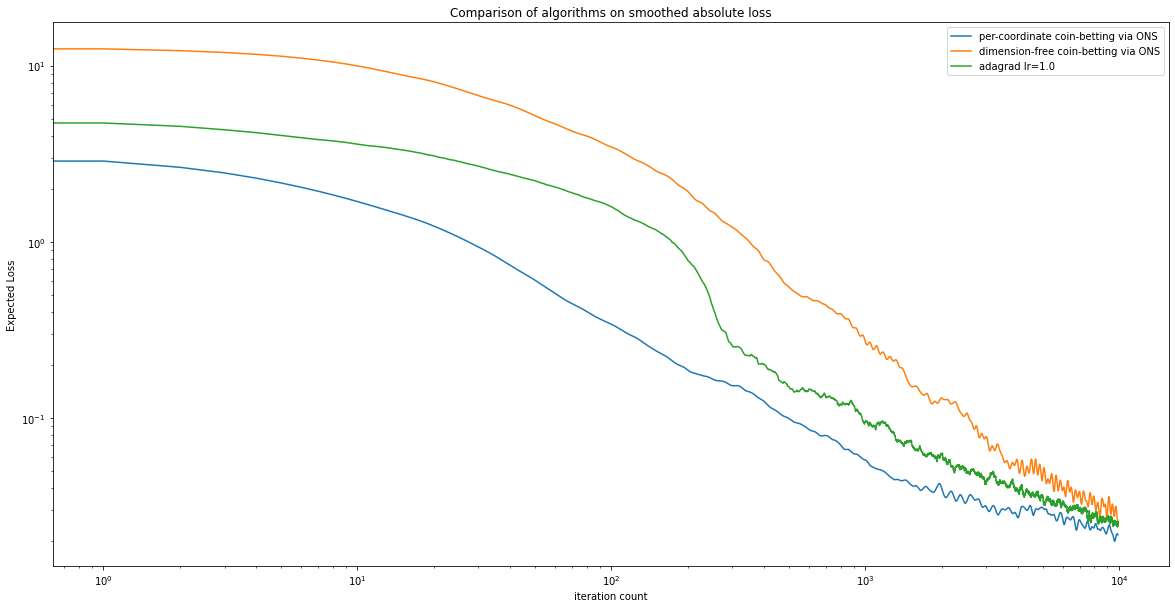

In [ ]:

dims = 1000 # dimension of optimization problem
noise_magnitude = 0.1 # amount of noise to add to gradients
num_iter = 10000 # number of iterations, decrease to make the notebook run faster

# technical options influencing shape of the loss function.
use_smoothed_absolute_loss = True # AdaGrad seems to be comparatively best with smoothing
optimal_point_scaling = 10.0 # scales distance between origin and optimal point.
eigenvalue_decay = 10.0 # larger values indicate *slower* decay of eigenvalues in M matrix in the loss.

initial_var_value = np.zeros(dims) #initial value of iterates

# dict of algorithms to test
algs = {
    'per-coordinate coin-betting via ONS': ONS_CB(initial_var_value, add_average=True, do_online_to_batch=True),
    'dimension-free coin-betting via ONS': ONS_CB_dim_free(initial_var_value, add_average=True, do_online_to_batch=True),

    # lr=1.0 is empirically the the best with the defaults in this notebook.
    'adagrad lr=1.0': AdaGrad(initial_var_value, lr=1.0),
    # 'adagrad lr=10': AdaGrad(var_value, lr=10.0),
    # 'adagrad lr=0.1': AdaGrad(var_value, lr=0.1),

    # Can try adagrad with all combinations if desired ( the default of False, False is best )
    # 'adagrad with online-to-batch': AdaGrad(var_value, lr=1.0, do_online_to_batch=True),
    # 'adagrad with adding average': AdaGrad(var_value,  lr=1.0, add_average=True),
    # 'adagrad with adding average and online-to-batch': AdaGrad(var_value, lr=1.0, add_average=True, do_online_to_batch=True),
}

run_and_plot_algorithms(dims, noise_magnitude, num_iter, use_smoothed_absolute_loss, algs, optimal_point_scaling, eigenvalue_decay)
